In [264]:
import numpy as np
import json
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.autograd.variable import Variable

In [326]:
def pose_to_numpy(frame):
    people = [person[1:] for person in frame]
    return np.array([[body_part[1] for body_part in person] for person in people])

class LetsDanceDataset(torch.utils.data.Dataset):
    categories_hash = {'tango': 0, 'break': 1, 'swing': 2,'quickstep': 3,
                  'foxtrot': 4,'pasodoble': 5,'tap': 6,'samba': 7,'flamenco': 8,
                  'ballet': 9,'rumba': 10,'waltz': 11,'cha': 12,'latin': 13,
                  'square': 14,'jive': 15}
    
    def __init__(self, root_dir, frames):
        super().__init__()

        # frames_index is [category, id, frame_no]
        self.root_dir = root_dir
        self.data = frames_index
        f.close()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        [category, dance_id, frames] = self.data[index]
        motion = []
        current_frame_path = "{}{}/{}.json".format(self.root_dir, category, dance_id)
        with open(current_frame_path) as f:
            motion = json.load(f)
            # for now, just return person 1 on the first frame, 
            # just to see if it generates any stick figures
            motion = np.array([pose_to_numpy(frame)[0].reshape(34) for frame in motion][0])
        return (motion, self.categories_hash[category])

In [327]:
with open('./dance-frame-list.json') as f:
    frames_index = json.load(f)
    np.random.shuffle(frames_index)
    
dataloader = LetsDanceDataset("../densepose/full/", frames_index)

In [267]:
def draw_points(points):
    plt.xlim(0, 1980)
    plt.ylim(-1000, 0)
    reshaped = points.reshape(17, 2)
    x = reshaped[:,0]
    y = reshaped[:,1]
    plt.scatter(x, -y, s=10, marker='.',)
    plt.show()

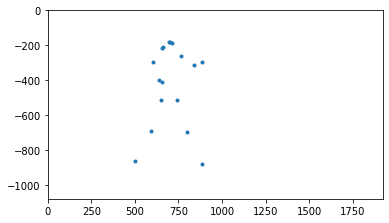

In [268]:
%matplotlib inline
from matplotlib import animation

motion = dataloader[0][0]

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0,1920), ylim=(-1080, 0))

motion_points = motion
reshaped = motion_points[0].reshape(17, 2)
x = reshaped[:,0]
y = reshaped[:,1]
body_points, = ax.plot(x, -y, '.')

def animate(frame):
    global body_points, motion_points
    reshaped = motion_points[frame].reshape(17, 2)
    x = reshaped[:,0]
    y = reshaped[:,1]
    body_points.set_data(x, -y)
    return body_points, 

anim = animation.FuncAnimation(fig, animate, frames=len(motion), interval=50)
plt.show()

In [294]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_features = 1 # The category
        n_out = 34 # 17 points (* 2 for x and y)
 
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    

In [390]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 34
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [391]:
def noise(size):
    n = Variable(torch.randn(size, 1))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [392]:
discriminator = Discriminator()
generator = Generator()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
    
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

In [393]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [370]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)

    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [368]:
num_test_samples = 16
num_batches = len(dataloader)
test_noise = noise(num_test_samples)

In [375]:
for epoch in range(num_epochs):
    for n_batch, (motion, label) in enumerate(dataloader):
        real_data = Variable(torch.FloatTensor(motion.reshape(1, 34)))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_data.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        print('Epoch {} Error D {} G {}. [{}/{}]'.format(epoch, d_error, g_error, n_batch, num_batches))
        

Epoch 0 Error D 0.21525521576404572 G 2.1619760990142822. [0/1463]
Epoch 0 Error D 0.12425895780324936 G 1.7650840282440186. [1/1463]
Epoch 1 Error D 0.19060511887073517 G 1.7170639038085938. [0/1463]
Epoch 1 Error D 0.05425942689180374 G 2.208592653274536. [1/1463]
Epoch 2 Error D 0.0899801030755043 G 2.2661514282226562. [0/1463]
Epoch 2 Error D 0.04101543873548508 G 2.0922811031341553. [1/1463]
Epoch 3 Error D 0.027919745072722435 G 4.739865303039551. [0/1463]
Epoch 3 Error D 0.12958750128746033 G 3.0823984146118164. [1/1463]
Epoch 4 Error D 0.025763358920812607 G 2.7416133880615234. [0/1463]
Epoch 4 Error D 0.02127121575176716 G 0.5543240308761597. [1/1463]
Epoch 5 Error D 0.12956680357456207 G 2.256467342376709. [0/1463]
Epoch 5 Error D 0.12923561036586761 G 3.03821063041687. [1/1463]
Epoch 6 Error D 0.03810451179742813 G 1.38872492313385. [0/1463]
Epoch 6 Error D 0.3420853614807129 G 2.9957008361816406. [1/1463]
Epoch 7 Error D 0.12482070922851562 G 2.5295960903167725. [0/1463]
Ep

Epoch 62 Error D 0.006000485271215439 G 5.47642707824707. [0/1463]
Epoch 62 Error D 0.0032781390473246574 G 3.605626106262207. [1/1463]
Epoch 63 Error D 0.0073449881747365 G 4.465699195861816. [0/1463]
Epoch 63 Error D 0.03630223125219345 G 2.8600172996520996. [1/1463]
Epoch 64 Error D 1.8794201612472534 G 4.431729793548584. [0/1463]
Epoch 64 Error D 27.663969039916992 G 1.906585693359375. [1/1463]
Epoch 65 Error D 0.0201357863843441 G 3.547804117202759. [0/1463]
Epoch 65 Error D 0.053626444190740585 G 5.102731227874756. [1/1463]
Epoch 66 Error D 0.034673985093832016 G 1.9750735759735107. [0/1463]
Epoch 66 Error D 0.031076060608029366 G 4.578970909118652. [1/1463]
Epoch 67 Error D 0.003171401098370552 G 2.4674439430236816. [0/1463]
Epoch 67 Error D 0.004903517197817564 G 4.6272783279418945. [1/1463]
Epoch 68 Error D 0.028055209666490555 G 5.321041107177734. [0/1463]
Epoch 68 Error D 0.0045749731361866 G 3.1952006816864014. [1/1463]
Epoch 69 Error D 0.03518505394458771 G 3.1810059547424

Epoch 122 Error D 0.2922663986682892 G 0.3653000593185425. [1/1463]
Epoch 123 Error D 0.5226216912269592 G 2.841986894607544. [0/1463]
Epoch 123 Error D 0.1092093288898468 G 0.7758898735046387. [1/1463]
Epoch 124 Error D 0.1039341613650322 G 1.9872220754623413. [0/1463]
Epoch 124 Error D 0.044805508106946945 G 2.619635581970215. [1/1463]
Epoch 125 Error D 0.7945523858070374 G 1.5532138347625732. [0/1463]
Epoch 125 Error D 0.07080346345901489 G 0.5739036798477173. [1/1463]
Epoch 126 Error D 1.021463394165039 G 0.5954474210739136. [0/1463]
Epoch 126 Error D 0.36852869391441345 G 3.827280282974243. [1/1463]
Epoch 127 Error D 0.19031588733196259 G 2.5390639305114746. [0/1463]
Epoch 127 Error D 0.26564377546310425 G 1.1859230995178223. [1/1463]
Epoch 128 Error D 0.021977439522743225 G 0.1009170338511467. [0/1463]
Epoch 128 Error D 0.4118815064430237 G 1.6160743236541748. [1/1463]
Epoch 129 Error D 0.06286419183015823 G 3.3405590057373047. [0/1463]
Epoch 129 Error D 0.09718339145183563 G 2.6

Epoch 183 Error D 0.0035906448028981686 G 3.8741941452026367. [0/1463]
Epoch 183 Error D 0.006353612057864666 G 5.382437229156494. [1/1463]
Epoch 184 Error D 0.016272500157356262 G 5.357541084289551. [0/1463]
Epoch 184 Error D 0.0025647361762821674 G 3.4623594284057617. [1/1463]
Epoch 185 Error D 0.014729867689311504 G 3.810292959213257. [0/1463]
Epoch 185 Error D 0.040382903069257736 G 4.572736740112305. [1/1463]
Epoch 186 Error D 0.001626860466785729 G 4.191756248474121. [0/1463]
Epoch 186 Error D 0.004485638812184334 G 5.706943511962891. [1/1463]
Epoch 187 Error D 0.009954421781003475 G 7.823104381561279. [0/1463]
Epoch 187 Error D 0.0045567103661596775 G 4.846397399902344. [1/1463]
Epoch 188 Error D 0.0007095469627529383 G 6.95322847366333. [0/1463]
Epoch 188 Error D 0.003143059089779854 G 3.4112026691436768. [1/1463]
Epoch 189 Error D 0.003088051686063409 G 5.270807266235352. [0/1463]
Epoch 189 Error D 0.0012768907472491264 G 6.989141464233398. [1/1463]
Epoch 190 Error D 0.1101506

In [336]:
dataloader[0][0].size

34

In [377]:
generator(noise(30))

tensor([[ 1.0000, -1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000, -1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000, -1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [ 1.0000, -1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000, -1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000, -1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
       grad_fn=<TanhBackward>)

In [401]:
discriminator(generator(noise(3)))

tensor([[0.5130],
        [0.5087],
        [0.5183]], grad_fn=<SigmoidBackward>)

In [381]:
dataloader[1]

(array([378.39746094, 295.95141602, 386.38766479, 285.96206665,
        364.4145813 , 285.96206665, 387.38644409, 294.95248413,
        333.45254517, 294.95248413, 397.37417603, 351.89172363,
        339.44519043, 352.89065552, 402.36807251, 426.8117981 ,
        422.34359741, 386.85443115, 434.32888794, 487.74676514,
        507.23953247, 401.83843994, 391.38153076, 531.69989014,
        331.45498657, 523.70837402, 428.33624268, 640.5836792 ,
        294.50027466, 650.57305908, 401.36929321, 717.50164795,
        287.5088501 , 717.50164795]),
 7)